C:\Users\aathe\AppData\Local\Temp\ipykernel_16800\1678526624.py:12: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date'] = pd.to_datetime(df['Date'])


Epoch 1/10
104/104 [==============================] - 3s 7ms/step - loss: 0.0141 - val_loss: 0.0045
Epoch 2/10
104/104 [==============================] - 0s 4ms/step - loss: 0.0092 - val_loss: 0.0042
Epoch 3/10
104/104 [==============================] - 0s 4ms/step - loss: 0.0088 - val_loss: 0.0048
Epoch 4/10
104/104 [==============================] - 0s 4ms/step - loss: 0.0082 - val_loss: 0.0046
Epoch 5/10
104/104 [==============================] - 0s 4ms/step - loss: 0.0079 - val_loss: 0.0052
Epoch 6/10
104/104 [==============================] - 0s 4ms/step - loss: 0.0077 - val_loss: 0.0052
Epoch 7/10
104/104 [==============================] - 0s 4ms/step - loss: 0.0077 - val_loss: 0.0055
Epoch 8/10
104/104 [==============================] - 0s 4ms/step - loss: 0.0076 - val_loss: 0.0052
Epoch 9/10
104/104 [==============================] - 0s 4ms/step - loss: 0.0075 - val_loss: 0.0046
Epoch 10/10
45/45 [==============================] - 0s 2ms/step - loss: 0.0094
Test Loss: 0.0094355

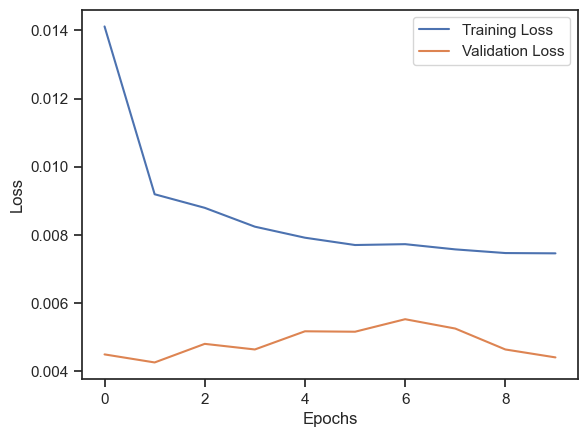

207/207 [==============================] - 1s 1ms/step

Training Results:
      Train Predictions   Actuals
0              0.168716  0.284912
1              0.165346  0.266934
2              0.163184  0.255377
3              0.157398  0.232745
4              0.158465  0.210112
...                 ...       ...
6619           0.081825  0.103852
6620           0.086946  0.088925
6621           0.094063  0.083467
6622           0.104348  0.101605
6623           0.104620  0.109791

[6624 rows x 2 columns]
45/45 [==============================] - 0s 2ms/step

Validation Results:
      Validation Predictions   Actuals
0                   0.104904  0.117335
1                   0.095209  0.109310
2                   0.095917  0.091814
3                   0.097529  0.103531
4                   0.100487  0.101124
...                      ...       ...
1414                0.158970  0.112681
1415                0.161784  0.098234
1416                0.166580  0.146228
1417                0.177398 

ValueError: operands could not be broadcast together with shapes (9463,4) (5,) (9463,4) 

In [15]:
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv('C:/Users/aathe/Documents/Datamod_ML_data.csv')

# Convert 'Date' column to datetime and set it as index
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Select the columns for inputs and target variable
input_cols = ['Precipitation(mm/day)', 'Temperature(2m)( C )', 'Wind speed (2m)(m/s)', 'Soil moisture(%)']
output_col = 'Daily Average Discharge(m3/sec)'

# Normalize the data
scaler = MinMaxScaler()
df_normalized = scaler.fit_transform(df[input_cols + [output_col]])

# Define a function to create input-output pairs
def df_to_x_y_multivariate(df, window_size=3):
    X = []
    y = []
    for i in range(len(df) - window_size):
        X.append(df[i:i+window_size, :-1])  # Input data
        y.append(df[i+window_size, -1])     # Output data (target)
    return np.array(X), np.array(y)

# Create input-output pairs
WINDOW_SIZE = 3
X, y = df_to_x_y_multivariate(df_normalized, WINDOW_SIZE)

# Split the data into train, validation, and test sets
split1 = int(0.7 * len(X))
split2 = int(0.85 * len(X))

X_train, y_train = X[:split1], y[:split1]
X_val, y_val = X[split1:split2], y[split1:split2]
X_test, y_test = X[split2:], y[split2:]

# Define and compile the model
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(64, input_shape=(WINDOW_SIZE, len(input_cols))),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)
])

model.compile(loss='mse', optimizer='adam')

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=64, verbose=1)

# Evaluate the model on the test set
test_loss = model.evaluate(X_test, y_test)
print('Test Loss:', test_loss)

# Plot training and validation losses
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Print results for training set
train_predictions = model.predict(X_train).flatten()
train_results = pd.DataFrame({'Train Predictions': train_predictions, 'Actuals': y_train})
print("\nTraining Results:")
print(train_results)

# Print results for validation set
val_predictions = model.predict(X_val).flatten()
val_results = pd.DataFrame({'Validation Predictions': val_predictions, 'Actuals': y_val})
print("\nValidation Results:")
print(val_results)

# Print results for test set
test_predictions = model.predict(X_test).flatten()
test_results = pd.DataFrame({'Test Predictions': test_predictions, 'Actuals': y_test})
print("\nTest Results:")
print(test_results)

# Calculate RMSE for training, validation, and test sets
train_rmse = mean_squared_error(y_train, train_predictions, squared=False)
val_rmse = mean_squared_error(y_val, val_predictions, squared=False)
test_rmse = mean_squared_error(y_test, test_predictions, squared=False)
print("\nTrain RMSE:", train_rmse)
print("Validation RMSE:", val_rmse)
print("Test RMSE:", test_rmse)

# Plot predictions vs actual values for the entire dataset
def plot_predictions_multivariate(model, X, y_true, scaler):
    y_pred = model.predict(X).flatten()
    # Inverse transform the predictions and true values to get them back to the original scale
    X_last = X[:, -1, :-1]  # Extract the last window of input features
    y_pred_original_scale = scaler.inverse_transform(np.hstack((X_last, y_pred.reshape(-1, 1))))
    y_true_original_scale = scaler.inverse_transform(np.hstack((X_last, y_true.reshape(-1, 1))))
    plt.plot(y_pred_original_scale[:, -1], label='Predictions')
    plt.plot(y_true_original_scale[:, -1], label='Actuals')
    plt.xlabel('Samples')
    plt.ylabel('Values')
    plt.legend()
    plt.show()

plot_predictions_multivariate(model, X, y, scaler)

# Plot predictions for the first 100 samples in test set
def plot_predictions_100_multivariate(model, X, y_true, scaler):
    y_pred = model.predict(X).flatten()
    # Inverse transform the predictions and true values to get them back to the original scale
    X_last = X[:, -1, :-1]  # Extract the last window of input features
    y_pred_original_scale = scaler.inverse_transform(np.hstack((X_last, y_pred.reshape(-1, 1))))
    y_true_original_scale = scaler.inverse_transform(np.hstack((X_last, y_true.reshape(-1, 1))))
    mse_score = mean_squared_error(y_true_original_scale[:, -1], y_pred_original_scale[:, -1])
    print('Mean Squared Error:', mse_score)
    plt.plot(y_pred_original_scale[:100, -1], label='Predictions')
    plt.plot(y_true_original_scale[:100, -1], label='Actuals')
    plt.xlabel('Samples')
    plt.ylabel('Values')
    plt.legend()
    plt.show()

plot_predictions_100_multivariate(model, X_test[:100], y_test[:100], scaler)


Epoch 1/100
213/213 [==============================] - 2s 3ms/step - loss: 0.0114 - val_loss: 0.0056
Epoch 2/100
213/213 [==============================] - 1s 3ms/step - loss: 0.0082 - val_loss: 0.0045
Epoch 3/100
213/213 [==============================] - 1s 3ms/step - loss: 0.0076 - val_loss: 0.0050
Epoch 4/100
213/213 [==============================] - 0s 2ms/step - loss: 0.0073 - val_loss: 0.0069
Epoch 5/100
213/213 [==============================] - 0s 2ms/step - loss: 0.0072 - val_loss: 0.0057
Epoch 6/100
213/213 [==============================] - 1s 2ms/step - loss: 0.0072 - val_loss: 0.0040
Epoch 7/100
213/213 [==============================] - 1s 2ms/step - loss: 0.0071 - val_loss: 0.0042
Epoch 8/100
213/213 [==============================] - 0s 2ms/step - loss: 0.0070 - val_loss: 0.0045
Epoch 9/100
213/213 [==============================] - 1s 2ms/step - loss: 0.0069 - val_loss: 0.0039
Epoch 10/100
213/213 [==============================] - 0s 2ms/step - loss: 0.0070 - val_lo

213/213 [==============================] - 1s 2ms/step - loss: 0.0062 - val_loss: 0.0043
Epoch 82/100
213/213 [==============================] - 1s 3ms/step - loss: 0.0062 - val_loss: 0.0054
Epoch 83/100
213/213 [==============================] - 1s 2ms/step - loss: 0.0061 - val_loss: 0.0042
Epoch 84/100
213/213 [==============================] - 1s 3ms/step - loss: 0.0061 - val_loss: 0.0049
Epoch 85/100
213/213 [==============================] - 1s 3ms/step - loss: 0.0061 - val_loss: 0.0046
Epoch 86/100
213/213 [==============================] - 1s 2ms/step - loss: 0.0061 - val_loss: 0.0040
Epoch 87/100
213/213 [==============================] - 1s 2ms/step - loss: 0.0061 - val_loss: 0.0037
Epoch 88/100
213/213 [==============================] - 1s 3ms/step - loss: 0.0061 - val_loss: 0.0036
Epoch 89/100
213/213 [==============================] - 1s 2ms/step - loss: 0.0061 - val_loss: 0.0038
Epoch 90/100
213/213 [==============================] - 1s 2ms/step - loss: 0.0062 - val_loss: 

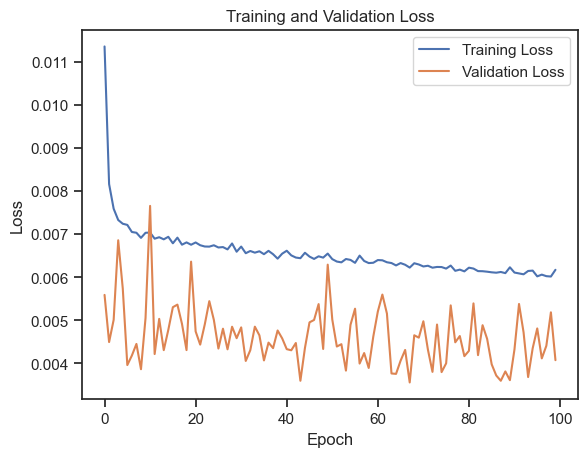

60/60 [==============================] - 0s 1ms/step
Root Mean Squared Error (RMSE): 0.0938443629376002


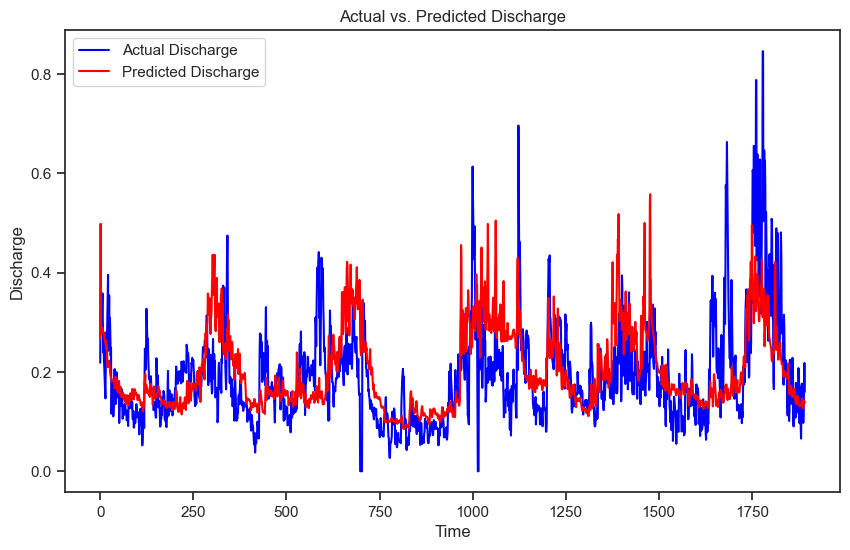

In [16]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Load CSV data
data = pd.read_csv('C:/Users/aathe/Documents/Datamod_ML_data.csv')

# Data Preprocessing
# Drop any NaN values
data = data.dropna()

# Feature scaling
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data.iloc[:, 1:])  # Exclude Date column

# Function to create sequences of data
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size, :-1])  # Input features
        y.append(data[i+window_size, -1])  # Output target
    return np.array(X), np.array(y)

# Define window size
window_size = 3  # Window period of 3 days

# Create sequences
X, y = create_sequences(scaled_data, window_size)

# Split data into train and test sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Build LSTM Model
model = Sequential([
    LSTM(units=50, activation='relu', input_shape=(window_size, X_train.shape[2])),
    Dense(units=50, activation='relu'),
    Dense(units=1)  # Output layer
])

# Compile model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=1, validation_split=0.1)

# Plot training loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate model
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error (RMSE):', rmse)

# Plot actual vs. predicted discharge
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual Discharge', color='blue')
plt.plot(y_pred, label='Predicted Discharge', color='red')
plt.title('Actual vs. Predicted Discharge')
plt.xlabel('Time')
plt.ylabel('Discharge')
plt.legend()
plt.show()


Epoch 1/100
207/207 [==============================] - 2s 3ms/step - loss: 0.0114 - val_loss: 0.0076
Epoch 2/100
207/207 [==============================] - 0s 2ms/step - loss: 0.0081 - val_loss: 0.0070
Epoch 3/100
207/207 [==============================] - 0s 2ms/step - loss: 0.0078 - val_loss: 0.0069
Epoch 4/100
207/207 [==============================] - 0s 2ms/step - loss: 0.0076 - val_loss: 0.0070
Epoch 5/100
207/207 [==============================] - 0s 2ms/step - loss: 0.0076 - val_loss: 0.0070
Epoch 6/100
207/207 [==============================] - 1s 2ms/step - loss: 0.0075 - val_loss: 0.0068
Epoch 7/100
207/207 [==============================] - 1s 2ms/step - loss: 0.0075 - val_loss: 0.0069
Epoch 8/100
207/207 [==============================] - 1s 2ms/step - loss: 0.0073 - val_loss: 0.0067
Epoch 9/100
207/207 [==============================] - 1s 2ms/step - loss: 0.0073 - val_loss: 0.0074
Epoch 10/100
207/207 [==============================] - 0s 2ms/step - loss: 0.0074 - val_lo

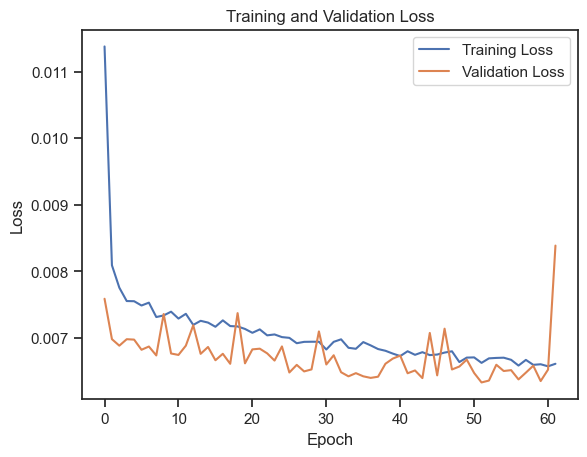

45/45 [==============================] - 0s 2ms/step
Root Mean Squared Error (RMSE) on Test Set: 0.08033895469372099


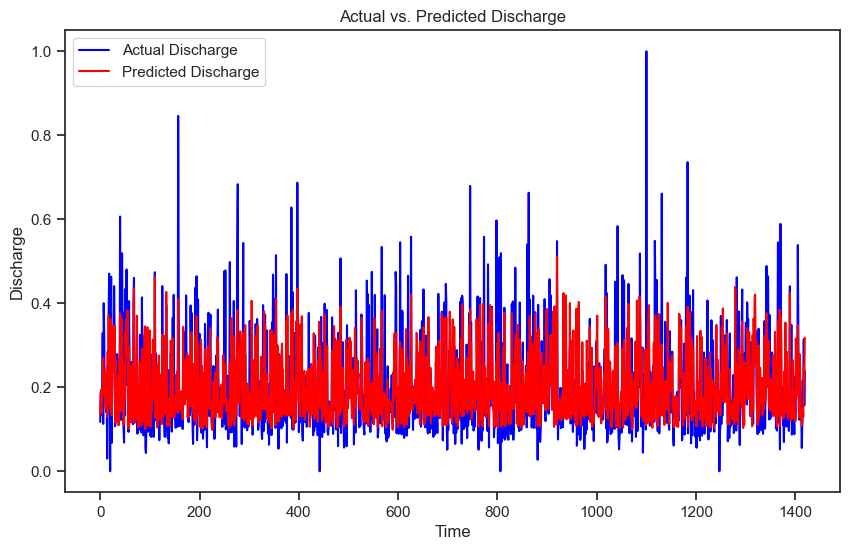

In [17]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping

# Load CSV data
data = pd.read_csv('C:/Users/aathe/Documents/Datamod_ML_data.csv')

# Data Preprocessing
# Drop any NaN values
data = data.dropna()

# Feature scaling
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data.iloc[:, 1:])  # Exclude Date column

# Function to create sequences of data
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size, :-1])  # Input features
        y.append(data[i+window_size, -1])  # Output target
    return np.array(X), np.array(y)

# Define window size
window_size = 3  # Window period of 3 days

# Create sequences
X, y = create_sequences(scaled_data, window_size)

# Split data into train, validation, and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.1765, random_state=42)  # 15/85 = 0.1765

# Build LSTM Model
model = Sequential([
    LSTM(units=50, activation='relu', input_shape=(window_size, X_train.shape[2])),
    Dense(units=50, activation='relu'),
    Dense(units=1)  # Output layer
])

# Compile model
model.compile(optimizer='adam', loss='mean_squared_error')

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=1, validation_data=(X_val, y_val), callbacks=[early_stopping])

# Plot training loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate model
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error (RMSE) on Test Set:', rmse)

# Plot actual vs. predicted discharge
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual Discharge', color='blue')
plt.plot(y_pred, label='Predicted Discharge', color='red')
plt.title('Actual vs. Predicted Discharge')
plt.xlabel('Time')
plt.ylabel('Discharge')
plt.legend()
plt.show()


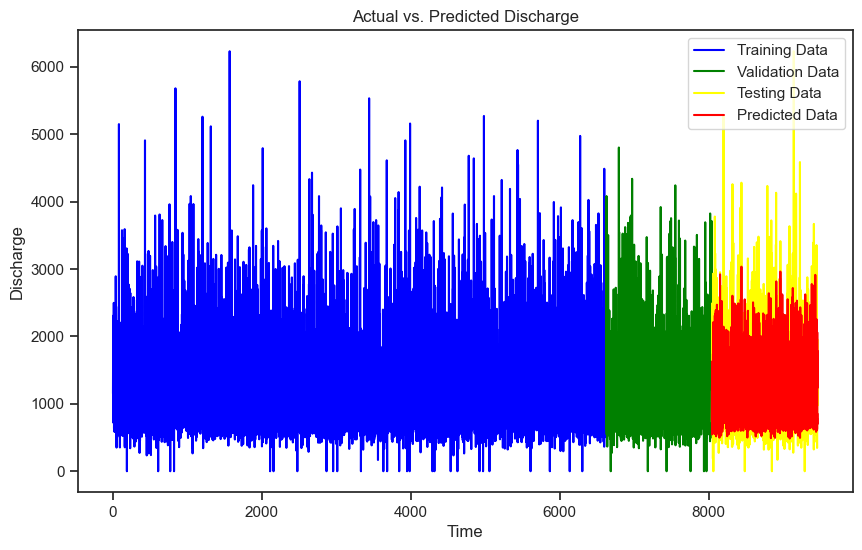

In [32]:
# Inverse transform the scaled training, validation, and testing data
y_train_inv = scalers[data.columns[-1]].inverse_transform(y_train.reshape(-1, 1))
y_val_inv = scalers[data.columns[-1]].inverse_transform(y_val.reshape(-1, 1))
y_test_inv = scalers[data.columns[-1]].inverse_transform(y_test.reshape(-1, 1))

# Plot actual vs. predicted discharge with different colors for train, validation, and test data
plt.figure(figsize=(10, 6))

# Plot training data
plt.plot(y_train_inv, label='Training Data', color='blue')

# Plot validation data
plt.plot(range(len(y_train_inv), len(y_train_inv) + len(y_val_inv)), y_val_inv, label='Validation Data', color='green')

# Plot testing data
plt.plot(range(len(y_train_inv) + len(y_val_inv), len(y_train_inv) + len(y_val_inv) + len(y_test_inv)), y_test_inv, label='Testing Data', color='yellow')

# Plot predicted data
plt.plot(range(len(y_train_inv) + len(y_val_inv), len(y_train_inv) + len(y_val_inv) + len(y_test_inv)), y_pred_inv, label='Predicted Data', color='red')

plt.title('Actual vs. Predicted Discharge')
plt.xlabel('Time')
plt.ylabel('Discharge')
plt.legend()
plt.show()


Epoch 1/50
207/207 [==============================] - 3s 4ms/step - loss: 0.0104 - val_loss: 0.0075
Epoch 2/50
207/207 [==============================] - 1s 3ms/step - loss: 0.0080 - val_loss: 0.0077
Epoch 3/50
207/207 [==============================] - 0s 2ms/step - loss: 0.0077 - val_loss: 0.0074
Epoch 4/50
207/207 [==============================] - 0s 2ms/step - loss: 0.0076 - val_loss: 0.0069
Epoch 5/50
207/207 [==============================] - 1s 3ms/step - loss: 0.0075 - val_loss: 0.0077
Epoch 6/50
207/207 [==============================] - 1s 5ms/step - loss: 0.0075 - val_loss: 0.0069
Epoch 7/50
207/207 [==============================] - 1s 3ms/step - loss: 0.0074 - val_loss: 0.0069
Epoch 8/50
207/207 [==============================] - 1s 3ms/step - loss: 0.0074 - val_loss: 0.0070
Epoch 9/50
207/207 [==============================] - 1s 4ms/step - loss: 0.0074 - val_loss: 0.0068
Epoch 10/50
207/207 [==============================] - 1s 3ms/step - loss: 0.0073 - val_loss: 0.0069

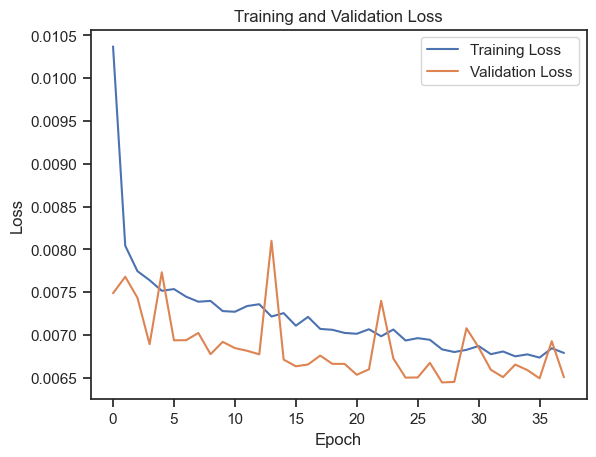

45/45 [==============================] - 0s 2ms/step
Root Mean Squared Error (RMSE) on Test Set: 502.81316743332513


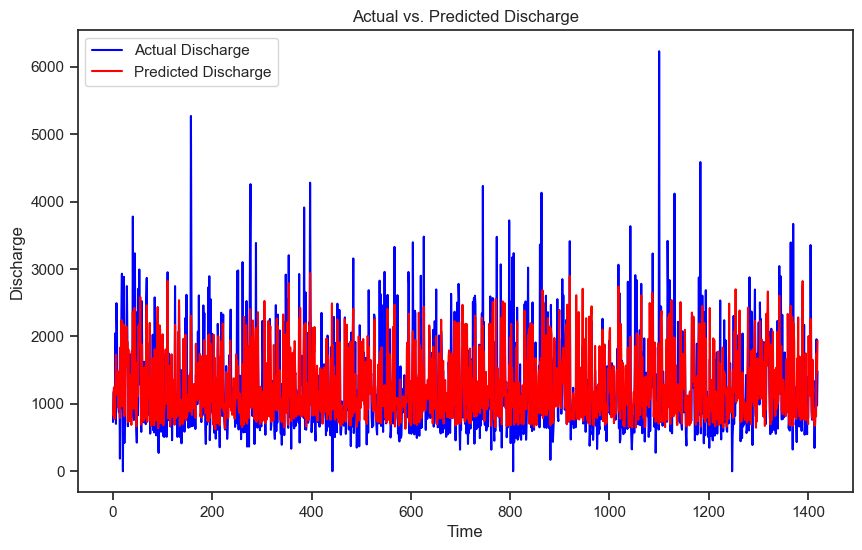

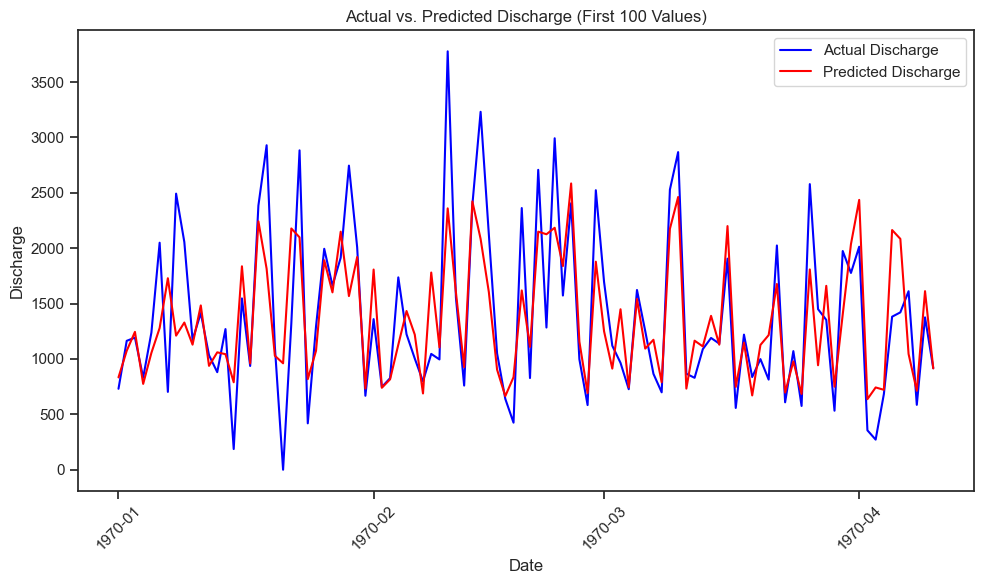

In [33]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
# Load CSV data
data = pd.read_csv('C:/Users/aathe/Documents/Datamod_ML_data.csv')

# Data Preprocessing
# Drop any NaN values
data = data.dropna()

# Separate features and target
X = data.iloc[:, 1:-1]  # Features (excluding Date and the last column)
y = data.iloc[:, -1]    # Target (last column)

# Feature scaling for each column individually
scalers = {}
for col in X.columns:
    scaler = MinMaxScaler(feature_range=(0, 1))
    X[col] = scaler.fit_transform(X[col].values.reshape(-1, 1))
    scalers[col] = scaler

# Scale target variable separately
scaler_y = MinMaxScaler(feature_range=(0, 1))
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))
scalers[data.columns[-1]] = scaler_y

# Function to create sequences of data
def create_sequences(data, target, window_size):
    X_seq, y_seq = [], []
    for i in range(len(data) - window_size):
        X_seq.append(data[i:i+window_size])  # Input features
        y_seq.append(target[i+window_size])   # Output target
    return np.array(X_seq), np.array(y_seq)

# Define window size
window_size = 3  # Window period of 3 days

# Create sequences
X_seq, y_seq = create_sequences(X.values, y_scaled, window_size)

# Split data into train, validation, and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X_seq, y_seq, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.1765, random_state=42)  # 15/85 = 0.1765

# Build LSTM Model
model = Sequential([
    LSTM(units=50, activation='relu', input_shape=(window_size, X_train.shape[2])),
    Dense(units=50, activation='relu'),
    Dense(units=1)  # Output layer
])

# Compile model
model.compile(optimizer='adam', loss='mean_squared_error')

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1, validation_data=(X_val, y_val), callbacks=[early_stopping])

# Plot training loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate model
y_pred = model.predict(X_test)

# Inverse transform the scaled predictions and actual values
y_test_inv = scalers[data.columns[-1]].inverse_transform(y_test.reshape(-1, 1))
y_pred_inv = scalers[data.columns[-1]].inverse_transform(y_pred)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
print('Root Mean Squared Error (RMSE) on Test Set:', rmse)

# Plot actual vs. predicted discharge
plt.figure(figsize=(10, 6))
plt.plot(y_test_inv, label='Actual Discharge', color='blue')
plt.plot(y_pred_inv, label='Predicted Discharge', color='red')
plt.title('Actual vs. Predicted Discharge')
plt.xlabel('Time')
plt.ylabel('Discharge')
plt.legend()
plt.show()

import matplotlib.dates as mdates
# Extract dates for the test set
test_dates = data.iloc[-len(y_test):, 0].values 
# Plot for the first 100 values with dates on the x-axis
plt.figure(figsize=(10, 6))
plt.plot(test_dates[:100], y_test_inv[:100], label='Actual Discharge', color='blue')
plt.plot(test_dates[:100], y_pred_inv[:100], label='Predicted Discharge', color='red')
plt.title('Actual vs. Predicted Discharge (First 100 Values)')
plt.xlabel('Date')
plt.ylabel('Discharge')
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())  # Set major ticks to monthly intervals
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # Format date labels
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()



In [34]:
# Define a function to forecast discharge for the next preceding 5 days
def forecast_next_5_days(model, last_3_days):
    forecasted_discharge = []
    input_sequence = last_3_days.reshape(1, window_size, last_3_days.shape[1])
    
    for _ in range(5):
        # Predict the discharge for the next day
        next_day_discharge = model.predict(input_sequence)
        forecasted_discharge.append(next_day_discharge[0, 0])  # Append the predicted discharge
        
        # Update the input sequence for the next prediction
        input_sequence = np.roll(input_sequence, -1, axis=1)  # Shift the sequence one step to the left
        input_sequence[0, -1] = next_day_discharge  # Update the last element with the predicted value
    
    return forecasted_discharge

# Take the last 3 days from the test set as input for forecasting
last_3_days_input = X_test[-1]

# Forecast discharge for the next preceding 5 days
forecasted_values = forecast_next_5_days(model, last_3_days_input)

# Inverse transform the forecasted values
forecasted_values_inv = scalers[data.columns[-1]].inverse_transform(np.array(forecasted_values).reshape(-1, 1))

# Print the forecasted values
print("Forecasted Discharge for the Next Preceding 5 Days:")
for i, value in enumerate(forecasted_values_inv):
    print(f"Day {i+1}: {value[0]}")


1/1 [==============================] - 0s 18ms/step
Forecasted Discharge for the Next Preceding 5 Days:
Day 1: 1937.7379150390625
Day 2: 1542.2537841796875
Day 3: 1473.4447021484375
Day 4: 1568.075439453125
Day 5: 1569.6165771484375


In [35]:
# Extract dates for the test set
test_dates = data.iloc[-len(y_test):, 0].values 
# Define the number of future days to forecast
num_future_days = 5

# Forecast discharge for future dates
forecasted_values_future = forecast_future_dates(model, last_3_days_input, num_future_days)

# Inverse transform the forecasted values
forecasted_values_future_inv = scalers[data.columns[-1]].inverse_transform(np.array(forecasted_values_future).reshape(-1, 1))

# Generate future dates starting from the last date in the test set
last_date = test_dates.iloc[-1] if not test_dates.empty else pd.Timestamp.today().floor('D')
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=num_future_days)

# Plot actual discharge and forecasted discharge for future dates
plt.figure(figsize=(10, 6))
plt.plot(test_dates, y_test_inv, label='Actual Discharge', color='blue')
plt.plot(future_dates, forecasted_values_future_inv, label='Forecasted Discharge (Future)', color='red', linestyle='--')
plt.title('Actual and Forecasted Discharge')
plt.xlabel('Date')
plt.ylabel('Discharge')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


1/1 [==============================] - 0s 28ms/step


AttributeError: 'numpy.ndarray' object has no attribute 'empty'

In [31]:
import matplotlib.pyplot as plt

# Plot actual and forecasted discharge
plt.figure(figsize=(10, 6))
actual_plot, = plt.plot(combined_dates[:10], combined_discharge[:10], color='blue', marker='o', linestyle='-', label='Actual Discharge', zorder=1)
forecasted_plot, = plt.plot(combined_dates[9:], combined_discharge[9:], color='red', marker='o', linestyle='--', label='Forecasted Discharge (Future)', zorder=2)

# Annotate forecasted values
for i, value in enumerate(forecasted_values_future_inv):
    index = i + 9  # Start index of forecasted values
    if i == len(forecasted_values_future_inv) - 1:
        plt.annotate(f'{value[0]:.2f} m³/sec', (combined_dates[index], value), textcoords="offset points", xytext=(30, 10), ha='center', fontsize=8, color='green', fontweight='bold')
    elif i == len(forecasted_values_future_inv) - 2:
        plt.annotate(f'{value[0]:.2f} m³/sec', (combined_dates[index], value), textcoords="offset points", xytext=(0, -10), ha='center', fontsize=8, color='green', fontweight='bold')
    else:
        plt.annotate(f'{value[0]:.2f} m³/sec', (combined_dates[index], value), textcoords="offset points", xytext=(0, 0), ha='center', fontsize=8, color='green', fontweight='bold')

plt.title('Actual and Forecasted Discharge')
plt.xlabel('Date')
plt.ylabel('Discharge')
plt.xticks(rotation=45)
plt.xticks(pd.date_range(start=combined_dates[0], end=combined_dates[-1], freq='D'))  # Set x-axis ticks to daily dates
plt.legend()
plt.tight_layout()
plt.show()


NameError: name 'combined_dates' is not defined

<Figure size 1000x600 with 0 Axes>

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load CSV data
data = pd.read_csv('C:/Users/aathe/Documents/Datamod_ML_data.csv')

# Data Preprocessing
# Drop any NaN values
data = data.dropna()

# Drop the 'Date' column
data = data.drop(columns=['Date'])

# Calculate correlation matrix
correlation_matrix = data.corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress

# Load CSV data
data = pd.read_csv('C:/Users/aathe/Documents/Datamod_ML_data.csv')

# Data Preprocessing
# Drop any NaN values
data = data.dropna()

# Drop the 'Date' column
data = data.drop(columns=['Date'])

# Function to plot correlation with best fit line
def plot_correlation_with_line(x, y, xlabel, ylabel):
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=x, y=y)
    
    # Calculate best fit line
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    line = slope * x + intercept
    plt.plot(x, line, color='red', label=f'Best Fit Line: y = {slope:.2f}x + {intercept:.2f}\nR2 = {r_value**2:.2f}')
    
    plt.title(f'Correlation between {xlabel} and {ylabel}')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot correlation with best fit line for each pair of features
for column in data.columns[:-1]:  # Exclude the last column (target variable)
    plot_correlation_with_line(data[column], data[data.columns[-1]], column, data.columns[-1])


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress

# Load CSV data
data = pd.read_csv('C:/Users/aathe/Documents/Datamod_ML_data.csv')

# Data Preprocessing
# Drop any NaN values
data = data.dropna()

# Drop the 'Date' column
data = data.drop(columns=['Date'])

# Function to calculate R-squared value
def calculate_r_squared(x, y):
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    return r_value ** 2

# Function to plot correlation matrix with R-squared values
def plot_correlation_matrix(data):
    sns.set(style='ticks')
    g = sns.pairplot(data, kind='scatter', diag_kind='kde')

    # Add R-squared values to scatter plots
    for ax_row in g.axes:
        for ax in ax_row:
            if ax.collections:  # Check if it's a scatter plot
                x = ax.collections[0].get_offsets()[:, 0]
                y = ax.collections[0].get_offsets()[:, 1]
                r_squared = calculate_r_squared(x, y)
                ax.annotate(f'R2 = {r_squared:.2f}', xy=(0.95, 0.95), xycoords='axes fraction', fontsize=8, color='red', ha='right', va='bottom')

    plt.show()

# Plot inter-correlations with R-squared values
plot_correlation_matrix(data)
